In [43]:
# THIS MODEL IS BUILT TO OVERFIT

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

import pickle
import matplotlib.pyplot as plt

import os
import glob

In [96]:
def see_images(imgs, labels):
    plt.figure(figsize = (10,5*len(imgs)))
    for i, img in enumerate(imgs):
      img = ((img / img.max()) * 255).astype(np.uint8)
      plt.subplot(int("1" + str(len(imgs) + 1) + str(i+1)))
      plt.imshow(img)
      plt.title(labels[i])
    plt.show()


def see_images_lr(left_image, right_image):
    plt.figure()
    plt.subplot(121)
    plt.imshow(np.array(left_image * 255).astype(np.uint8), interpolation='none')
    plt.subplot(122)
    plt.imshow(np.array(right_image * 255).astype(np.uint8), interpolation='none')
    plt.show()

def unpack_pickle(path_with_file_name):
    x = y = None
    with open(path_with_file_name, 'rb') as pickle_file:
        data = pickle.load(pickle_file)
        x = data[0]
        y = data[1]
        # Need to take out empty array in x set, since there is a left over array on the left side of the list for each image (see comment at top of file)
        x = [temp[1] for temp in x]
    return x, y

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
os.chdir('/content/drive/Shareddrives/ECE_792_Advanced_Topics_in_ML/compressed_images')


Train Image


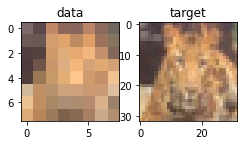

X Train Image Shape: (8, 8, 3)
Y Train Image Shape: (32, 32, 3)
Valid Image


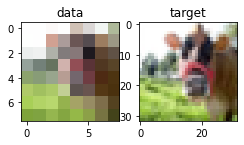

X Valid Image Shape: (8, 8, 3)
Y VaLid Image Shape: (32, 32, 3)
Test Image


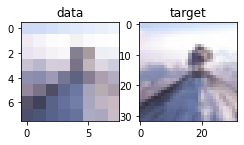

X Test Image Shape: (8, 8, 3)
Y Test Image Shape: (32, 32, 3)


In [92]:
# Unpickle Data
path = "./cifar-data/"
train_file_path = path + "train_32_16_4_8.dat"
valid_file_path = path + "valid_32_16_4_8.dat"
test_file_path = path + "test_32_16_4_8.dat"
x_train, y_train = unpack_pickle(train_file_path)
x_valid, y_valid = unpack_pickle(valid_file_path)
x_test, y_test = unpack_pickle(test_file_path)

# # downsize number of images
# x_train, y_train = x_train[:10], y_train[:10]
# x_valid, y_valid = x_valid[:10], y_valid[:10]
# x_test, y_test = x_test[:10], y_test[:10]


print("Train Image")
see_images([x_train[0], y_train[0]], ["data", "target"])
x_image_shape = x_train[0].shape
y_image_shape = y_train[0].shape
print("X Train Image Shape:", x_image_shape)
print("Y Train Image Shape:", y_image_shape)

print("Valid Image")
see_images([x_valid[0], y_valid[0]], ["data", "target"])
x_image_shape = x_valid[0].shape
y_image_shape = y_train[0].shape
print("X Valid Image Shape:", x_image_shape)
print("Y VaLid Image Shape:", y_image_shape)


print("Test Image")
see_images([x_test[0], y_test[0]],["data", "target"])
x_image_shape = x_test[0].shape
y_image_shape = y_test[0].shape
print("X Test Image Shape:", x_image_shape)
print("Y Test Image Shape:", y_image_shape)






In [48]:
# Need to resize the numpy array, since Conv2D expects (number, rgb channels, x, y)

def prepare_data_for_dataset(x, y):
    x = np.stack( x, axis=0)
    x = x.swapaxes(1, 3)
    y = np.stack( y, axis=0)
    y = y.swapaxes(1, 3)
    return x, y

x_train, y_train = prepare_data_for_dataset(x_train, y_train)
print("x_train new dimensions:", x_train.shape)
print("y_train new dimensions:", y_train.shape)

x_valid, y_valid = prepare_data_for_dataset(x_valid, y_valid)
print("x_valid new dimensions:", x_valid.shape)
print("y_valid new dimensions:", y_valid.shape)

x_test, y_test = prepare_data_for_dataset(x_test, y_test)
print("x_test new dimensions:", x_valid.shape)
print("y_test new dimensions:", y_valid.shape)

x_train new dimensions: (45000, 3, 8, 8)
y_train new dimensions: (45000, 3, 32, 32)
x_valid new dimensions: (5000, 3, 8, 8)
y_valid new dimensions: (5000, 3, 32, 32)
x_test new dimensions: (5000, 3, 8, 8)
y_test new dimensions: (5000, 3, 32, 32)


In [49]:
# Need to take images and place into dataset for easier use of data loader
class CompressionDataset(Dataset):
    def __init__(self, compressed_images, original_images, transforms=None) -> None:
        
        # scale input from 0 to 1
        self.original = original_images/255
        self.compressed = compressed_images/255
        
        
        if transforms != None: 
            for transform in transforms:
                self.original = transform(self.original)
                self.compressed = transform(self.compressed)
        super().__init__()
    def __len__(self):
        return len(self.original)
    def __getitem__(self, index):
        original_image = self.original[index]
        compressed_image = self.compressed[index]
        sample = {"Compressed":compressed_image, "Original":original_image}
        return sample


def ToTensor(array):
    return torch.from_numpy(array).float()


Train Image <class 'torch.Tensor'>
Test Image <class 'torch.Tensor'>
tensor(0.3373) tensor(0.6971)


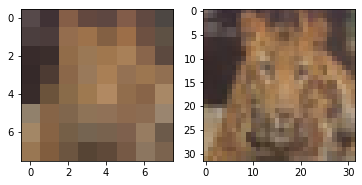

test tensor(0.8179)


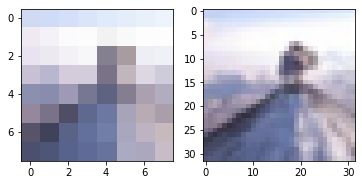

In [50]:

# Convert each set of images to a dataset

train_data_set = CompressionDataset(x_train, y_train, transforms= [ToTensor])
valid_data_set = CompressionDataset(x_valid, y_valid, transforms=[ToTensor])
test_data_set = CompressionDataset(x_test, y_test, transforms=[ToTensor])
batch_size = 32

image = train_data_set.compressed[0]

print("Train Image", type(image[0][0][0]))

image = test_data_set.compressed[0]
print("Test Image", type(image[0][0][0]))

train_data_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=False)
valid_data_loader = DataLoader(valid_data_set, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_data_set, batch_size=batch_size, shuffle=False)

#Testing Data Loader to see if it got our data correctly
for (idx, batch) in enumerate(train_data_loader):
    print(batch["Compressed"][0][0][0][0], batch["Compressed"][0].max())
    see_images(batch["Compressed"][0].swapaxes(0, 2), batch["Original"][0].swapaxes(0, 2))
    break # We just want first image in batch

for (idx, batch) in enumerate(test_data_loader):
    print("test",batch["Compressed"][0][0][0][0])
    see_images(batch["Compressed"][0].swapaxes(0, 2), batch["Original"][0].swapaxes(0, 2))
    break # We just want first image in batch

In [51]:
class Residual_Model(nn.Module):
    def __init__(self) -> None:
        super(Residual_Model, self).__init__()
        self.up_2x = nn.Upsample(scale_factor = 2, mode='nearest')

        # do a convtranspose2d????
        self.conv1 = nn.Conv2d(3, 16, 2, padding = 'same')
        self.batchnorm1 = nn.BatchNorm2d(16)

        self.upconv1 =  nn.ConvTranspose2d(16, 64, 2, stride=2, padding=0)
        # concatenate upsampled
        self.batchnorm2 = nn.BatchNorm2d(64 + 3)

        self.conv2 = nn.Conv2d(64 + 3, 128, 2, padding = 'same')
        self.batchnorm3 = nn.BatchNorm2d(128)

        self.upconv2 = nn.ConvTranspose2d(128, 32, 2, stride=2, padding=0)
        # concatenate upsampled
        self.batchnorm4 = nn.BatchNorm2d(32 + 3)

        self.conv3 = nn.Conv2d(32+3, 3, 2, padding = 'same')

        # self.batchnorm1 = nn.BatchNorm2d(40) 
        # self.batchnor
        m2 = nn.BatchNorm2d(3)

# https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11#:~:text=Transposed%20convolutions%20are%20standard%20convolutions,in%20a%20standard%20convolution%20operation.
    def forward(self, x):
        # convolve 
        input = x
        x = self.batchnorm1(func.relu(self.conv1(x)))

        # upconv and concatenate upsampled 
        print(torch.cat((self.up_2x(input), self.upconv1(x)), dim=1).shape)
        x = torch.cat((self.up_2x(input), self.upconv1(x)), dim=1)
        x = self.batchnorm2(func.relu(x))

        # convolve
        x = self.batchnorm3(func.relu(self.conv2(x)))

        # up conv and concatenate upsampled
        x = torch.cat((self.up_2x(self.up_2x(input)), self.upconv2(x)), dim=1)
        x = self.batchnorm4(func.relu(x))

        x = func.relu(self.conv3(x))
        return func.softmax(x)

# Test to see if it was working! 
for (idx, batch) in enumerate(train_data_loader):
    in_image = batch["Compressed"]
    test_net = Residual_Model()
    test_image = test_net.forward(in_image)
    # print(test_image)
    break


torch.Size([32, 67, 16, 16])


<ipython-input-51-e647c0995059>:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return func.softmax(x)


In [52]:
class Dense_Connection_Model(nn.Module):
    # https://www.analyticsvidhya.com/blog/2021/05/deep-learning-for-image-super-resolution/#:~:text=Super%2DResolution%20Generative%20Adversarial%20Network,match%20the%20true%20training%20data.
    # option (d) from above
    # arXiv:1501.00092v3 [cs.CV] 31 Jul 2015 -> simple (used this one)
    # arXiv:1707.02921v1 [cs.CV] 10 Jul 2017 -> complex


    def __init__(self) -> None:
        super(Dense_Connection_Model, self).__init__()
        self.up_2x = nn.Upsample(scale_factor = 4, mode='bicubic')

        self.cnn1 = nn.Conv2d(3, 64, 9, padding = 'same')
        self.cnn2 = nn.Conv2d(64, 32, 1, padding = 'same')
        self.output = nn.Conv2d(32, 3, 5, padding = 'same')
        
    def forward(self, x):
        x = self.up_2x(x)
        x = func.relu(self.cnn1(x))
        x = func.relu(self.cnn2(x))
        return self.output(x)

# Test to see if it was working! 
for (idx, batch) in enumerate(train_data_loader):
    in_image = batch["Compressed"]
    test_net = Dense_Connection_Model()
    test_image = test_net.forward(in_image)
    # print(test_image)
    break


In [53]:
img = batch["Compressed"][0]#.swapaxes(0, 2)
img = torch.reshape(img, (1, 3, 8, 8))
print(img.shape)
up = nn.Upsample(scale_factor = 4, mode='bicubic')


torch.Size([1, 3, 8, 8])


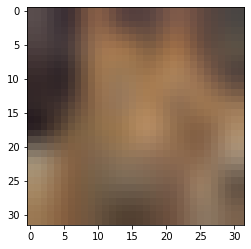

In [54]:
plt.imshow(torch.reshape(up(img), (3, 32, 32)).swapaxes(0,2))

In [55]:
from torchsummary import summary

vgg = Dense_Connection_Model()
summary(vgg, (3, 8, 8))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 64, 32, 32]          15,616
            Conv2d-3           [-1, 32, 32, 32]           2,080
            Conv2d-4            [-1, 3, 32, 32]           2,403
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.80
Params size (MB): 0.08
Estimated Total Size (MB): 0.87
----------------------------------------------------------------


In [97]:
# Ripped this part off of (will make a custom one later): https://nextjournal.com/gkoehler/pytorch-mnist
train_losses = []
train_counter = []
test_losses = []
n_epochs = 5
momentum = 0.5
learning_rate = 0.1
log_interval = 10
network = Dense_Connection_Model()
test_counter = [i*len(train_data_loader.dataset) for i in range(n_epochs + 1)]
optimizer = optim.Adam(network.parameters())



In [98]:


def train(epoch):
  network.train()
  for idx, batch in enumerate(train_data_loader):
    optimizer.zero_grad()
    output = network(batch["Compressed"])
    loss_func = nn.MSELoss()
    loss = loss_func(output, batch["Original"])
    loss.backward()
    optimizer.step()
    if idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, idx * len(batch["Compressed"]), len(train_data_loader.dataset),
        100. * idx / len(train_data_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (idx*64) + ((epoch-1)*len(train_data_loader.dataset)))
      # torch.save(network.state_dict(), './results/model.pth')
      # torch.save(optimizer.state_dict(), './results/optimizer.pth')

def test(): # Need to figure out how to evaluate based on loss
  network.eval()
  test_loss = 0
  correct = 0
  loss_func = nn.MSELoss(reduction='sum')
  with torch.no_grad():
    # for idx, batch in enumerate(test_data_loader):
    for idx, batch in enumerate(train_data_loader):

      output = network(batch["Compressed"])
      print("Loss:", loss_func(output,batch["Original"] ))
      for idx, image in enumerate(output):
        x = batch["Compressed"][idx].numpy().swapaxes(0, 2)
        y_hat = image.numpy().swapaxes(0, 2)
        y = batch["Original"][idx].numpy().swapaxes(0, 2)
        see_images([x, y_hat, y], ["x", "y_hat", "y"])
      break

Loss: tensor(28612.7129)


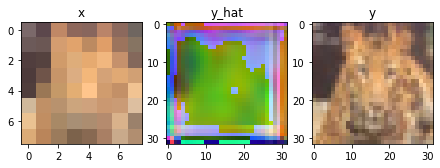

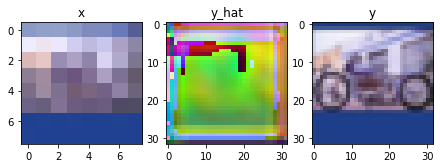

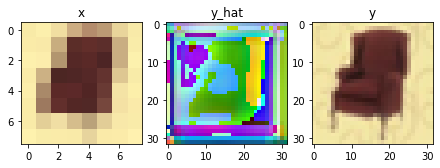

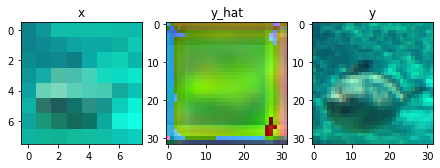

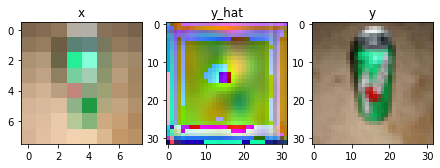

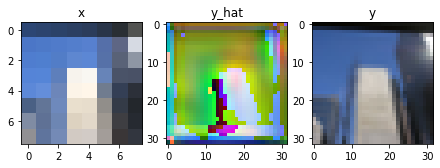

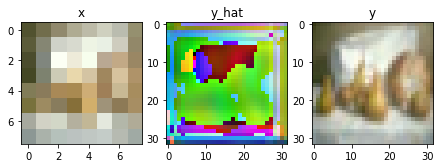

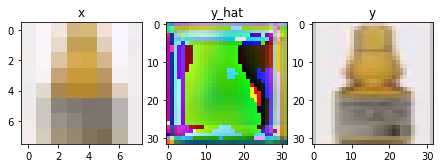

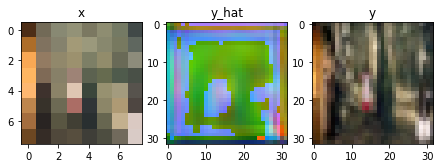

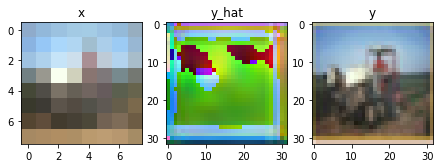

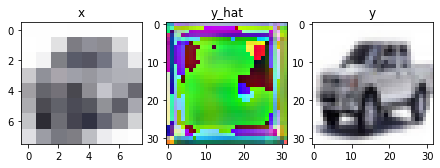

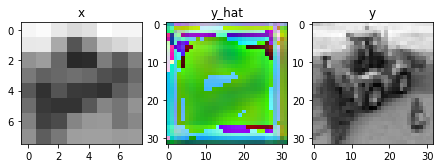

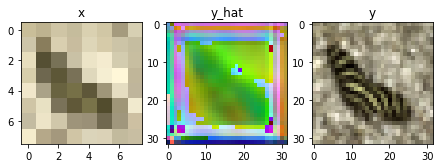

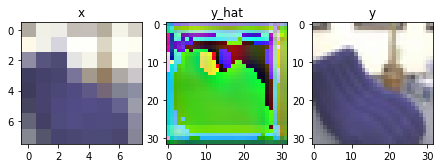

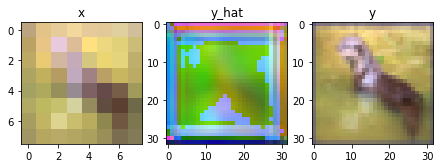

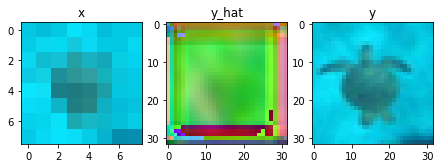

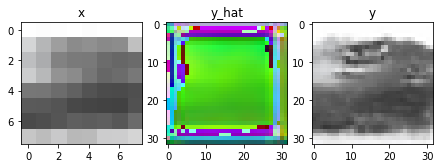

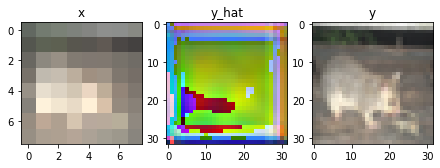

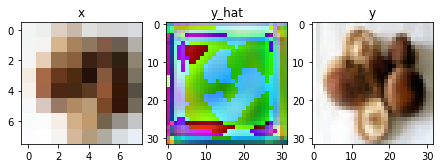

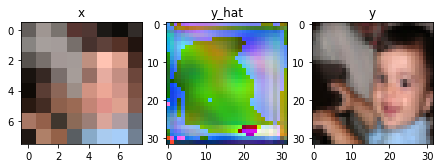

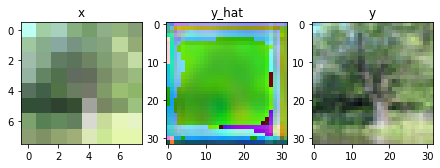

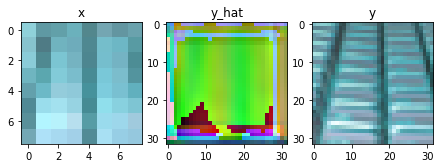

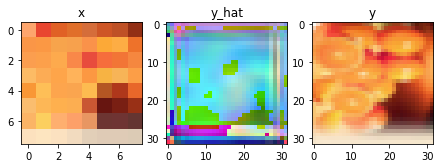

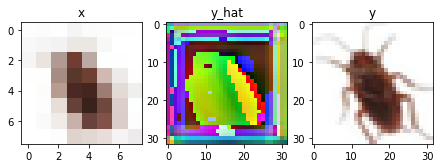

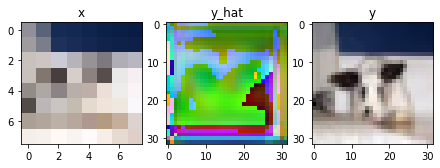

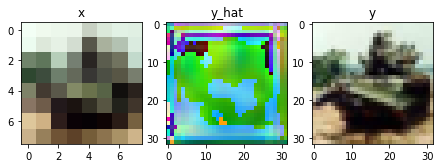

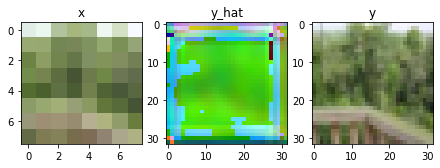

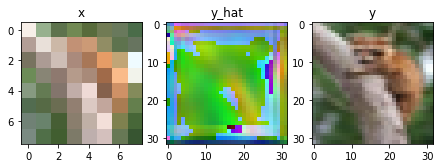

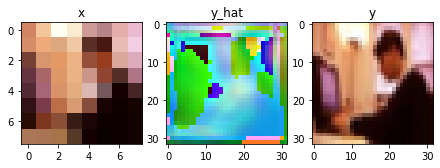

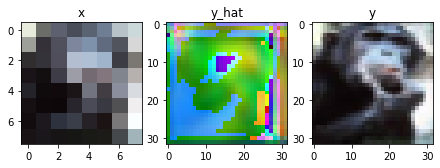

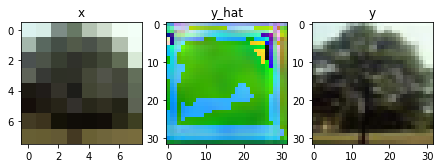

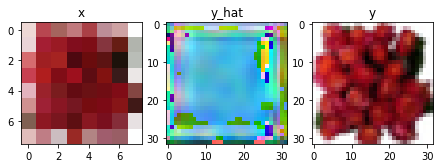

Train Epoch: 1 [0/45000 (0%)]	Loss: 0.291064
Train Epoch: 1 [320/45000 (1%)]	Loss: 0.045340
Train Epoch: 1 [640/45000 (1%)]	Loss: 0.042378
Train Epoch: 1 [960/45000 (2%)]	Loss: 0.030328
Train Epoch: 1 [1280/45000 (3%)]	Loss: 0.021388
Train Epoch: 1 [1600/45000 (4%)]	Loss: 0.018036
Train Epoch: 1 [1920/45000 (4%)]	Loss: 0.017607
Train Epoch: 1 [2240/45000 (5%)]	Loss: 0.014405
Train Epoch: 1 [2560/45000 (6%)]	Loss: 0.015162
Train Epoch: 1 [2880/45000 (6%)]	Loss: 0.012313
Train Epoch: 1 [3200/45000 (7%)]	Loss: 0.010782
Train Epoch: 1 [3520/45000 (8%)]	Loss: 0.009284
Train Epoch: 1 [3840/45000 (9%)]	Loss: 0.010166
Train Epoch: 1 [4160/45000 (9%)]	Loss: 0.008324
Train Epoch: 1 [4480/45000 (10%)]	Loss: 0.010114
Train Epoch: 1 [4800/45000 (11%)]	Loss: 0.010204
Train Epoch: 1 [5120/45000 (11%)]	Loss: 0.010003
Train Epoch: 1 [5440/45000 (12%)]	Loss: 0.008513
Train Epoch: 1 [5760/45000 (13%)]	Loss: 0.008820
Train Epoch: 1 [6080/45000 (14%)]	Loss: 0.011213
Train Epoch: 1 [6400/45000 (14%)]	Loss: 

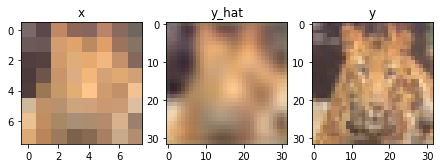

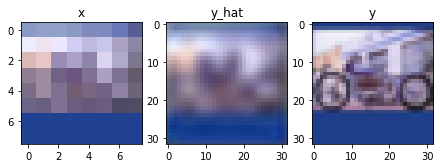

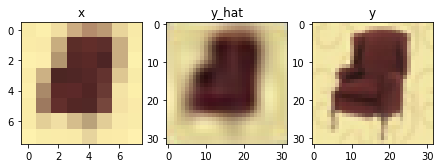

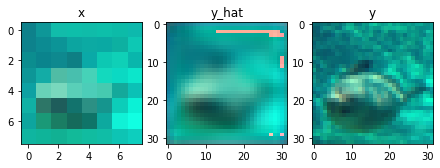

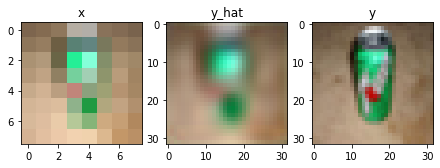

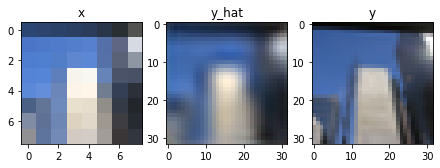

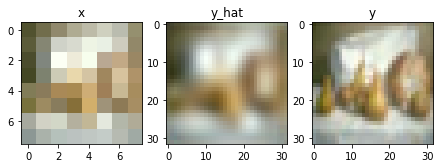

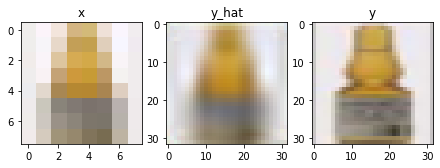

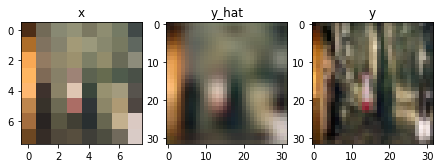

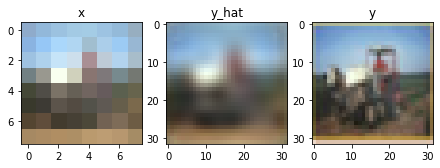

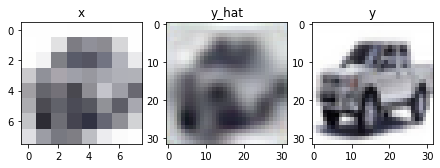

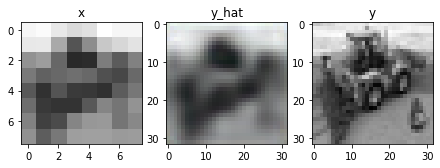

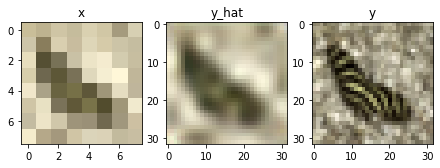

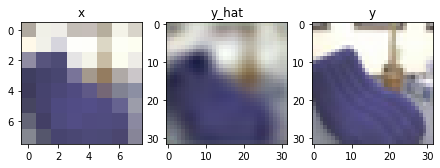

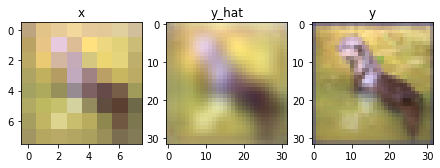

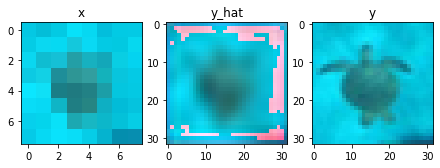

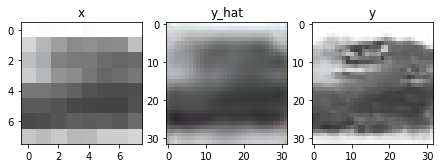

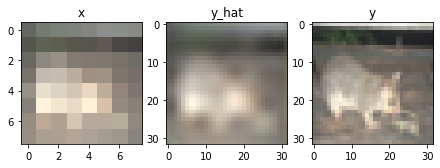

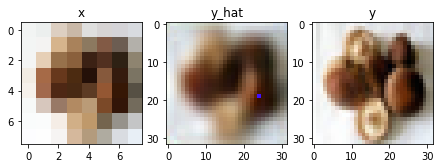

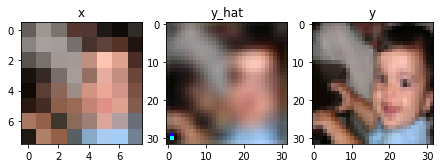

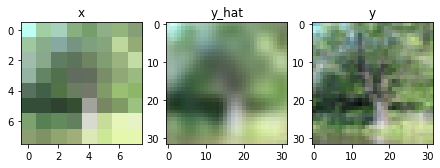

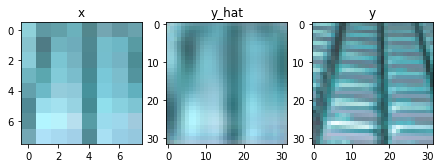

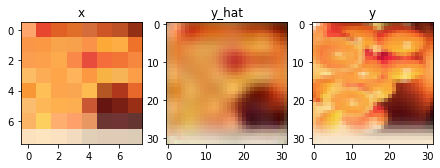

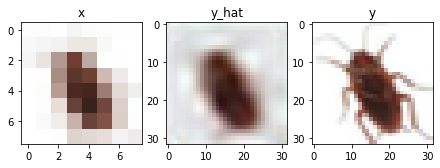

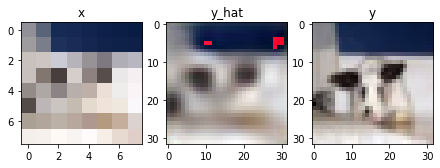

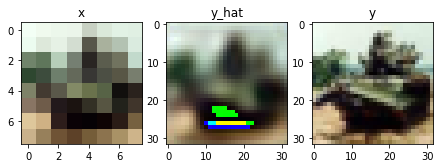

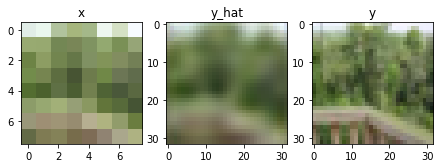

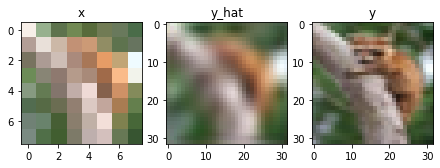

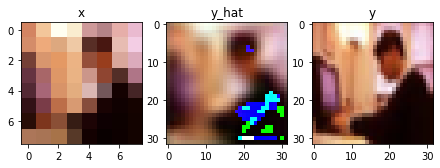

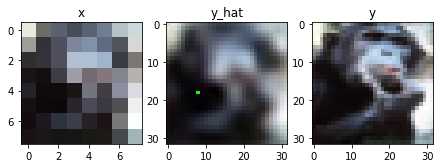

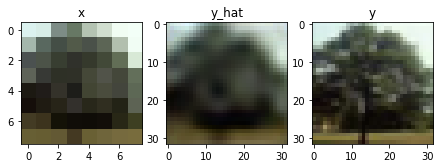

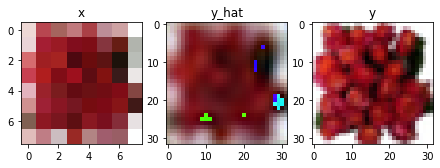

Train Epoch: 2 [0/45000 (0%)]	Loss: 0.008233
Train Epoch: 2 [320/45000 (1%)]	Loss: 0.007852
Train Epoch: 2 [640/45000 (1%)]	Loss: 0.007888
Train Epoch: 2 [960/45000 (2%)]	Loss: 0.010294
Train Epoch: 2 [1280/45000 (3%)]	Loss: 0.006578
Train Epoch: 2 [1600/45000 (4%)]	Loss: 0.007235
Train Epoch: 2 [1920/45000 (4%)]	Loss: 0.008819
Train Epoch: 2 [2240/45000 (5%)]	Loss: 0.008254
Train Epoch: 2 [2560/45000 (6%)]	Loss: 0.009230
Train Epoch: 2 [2880/45000 (6%)]	Loss: 0.008528
Train Epoch: 2 [3200/45000 (7%)]	Loss: 0.007433
Train Epoch: 2 [3520/45000 (8%)]	Loss: 0.006770
Train Epoch: 2 [3840/45000 (9%)]	Loss: 0.007706
Train Epoch: 2 [4160/45000 (9%)]	Loss: 0.006050
Train Epoch: 2 [4480/45000 (10%)]	Loss: 0.008111
Train Epoch: 2 [4800/45000 (11%)]	Loss: 0.008022
Train Epoch: 2 [5120/45000 (11%)]	Loss: 0.008378
Train Epoch: 2 [5440/45000 (12%)]	Loss: 0.007033
Train Epoch: 2 [5760/45000 (13%)]	Loss: 0.007558
Train Epoch: 2 [6080/45000 (14%)]	Loss: 0.009199
Train Epoch: 2 [6400/45000 (14%)]	Loss: 

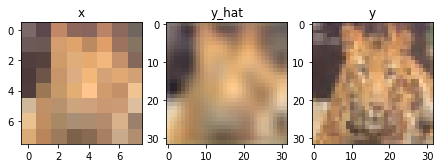

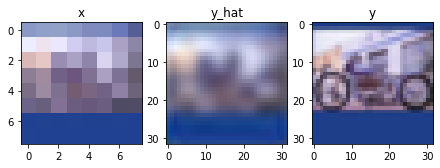

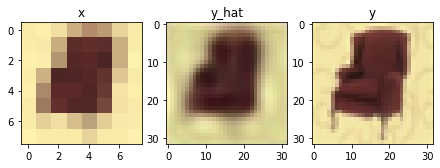

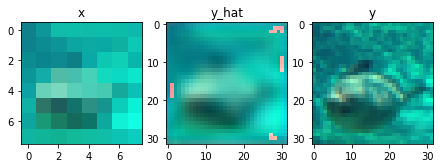

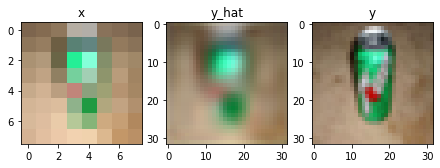

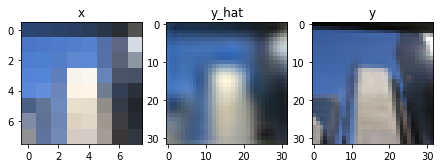

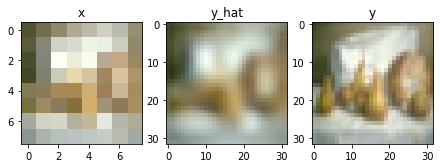

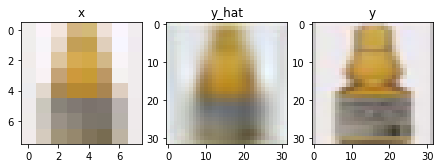

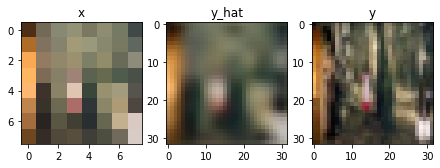

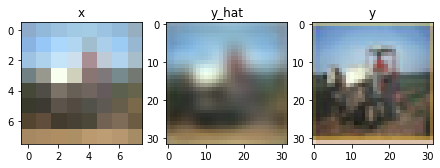

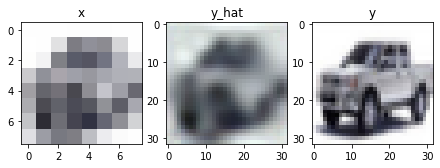

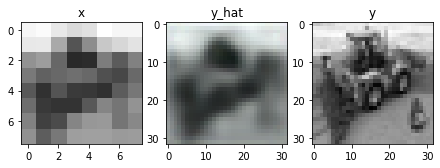

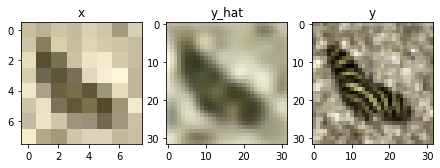

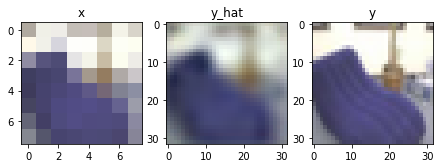

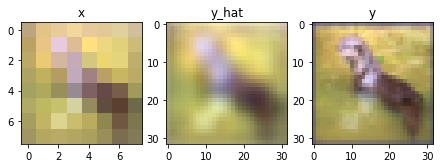

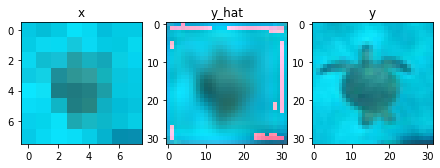

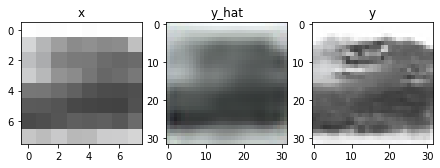

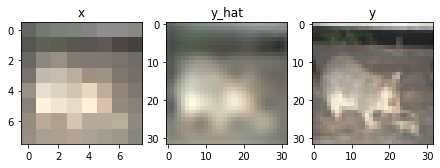

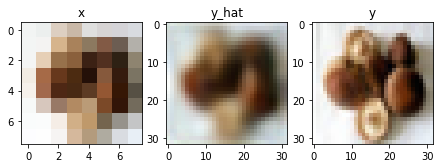

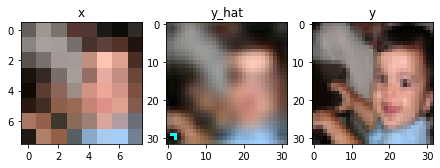

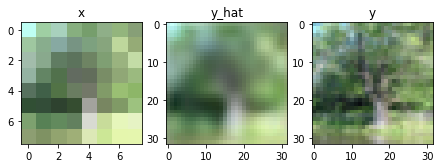

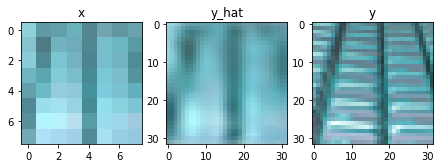

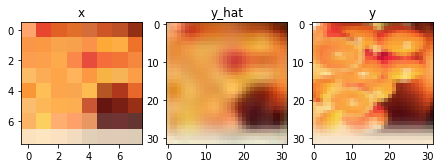

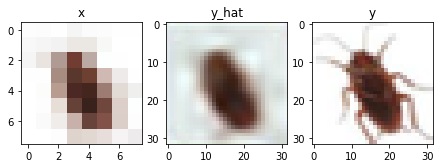

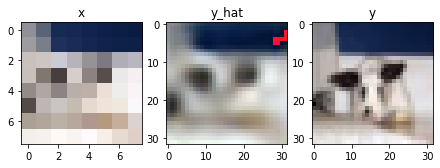

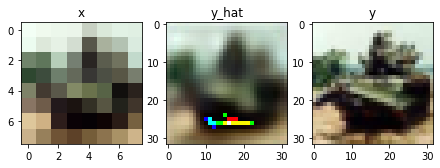

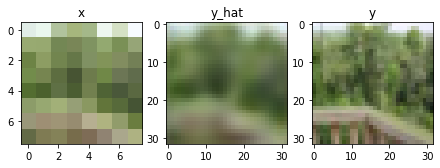

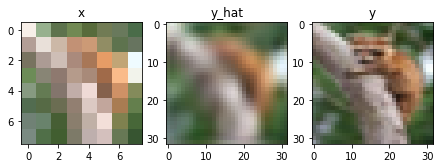

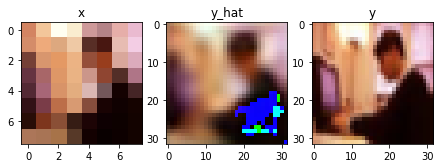

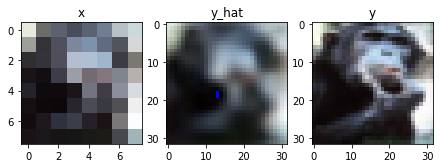

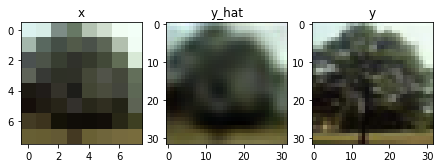

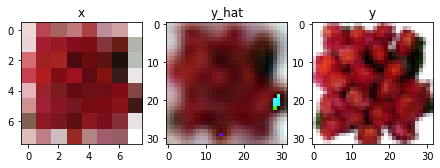

Train Epoch: 3 [0/45000 (0%)]	Loss: 0.008106
Train Epoch: 3 [320/45000 (1%)]	Loss: 0.007720
Train Epoch: 3 [640/45000 (1%)]	Loss: 0.007572
Train Epoch: 3 [960/45000 (2%)]	Loss: 0.010084
Train Epoch: 3 [1280/45000 (3%)]	Loss: 0.006265
Train Epoch: 3 [1600/45000 (4%)]	Loss: 0.007157
Train Epoch: 3 [1920/45000 (4%)]	Loss: 0.008668
Train Epoch: 3 [2240/45000 (5%)]	Loss: 0.008003
Train Epoch: 3 [2560/45000 (6%)]	Loss: 0.009017
Train Epoch: 3 [2880/45000 (6%)]	Loss: 0.008284
Train Epoch: 3 [3200/45000 (7%)]	Loss: 0.007253
Train Epoch: 3 [3520/45000 (8%)]	Loss: 0.006497
Train Epoch: 3 [3840/45000 (9%)]	Loss: 0.007514
Train Epoch: 3 [4160/45000 (9%)]	Loss: 0.005679
Train Epoch: 3 [4480/45000 (10%)]	Loss: 0.007928
Train Epoch: 3 [4800/45000 (11%)]	Loss: 0.007967
Train Epoch: 3 [5120/45000 (11%)]	Loss: 0.008361
Train Epoch: 3 [5440/45000 (12%)]	Loss: 0.006834
Train Epoch: 3 [5760/45000 (13%)]	Loss: 0.007460
Train Epoch: 3 [6080/45000 (14%)]	Loss: 0.009004
Train Epoch: 3 [6400/45000 (14%)]	Loss: 

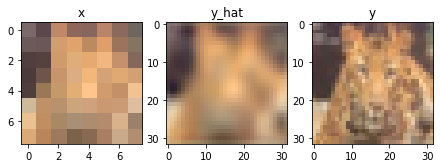

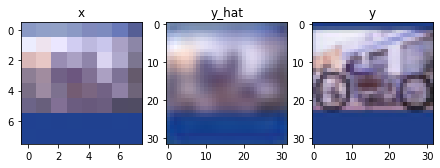

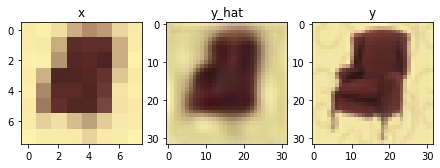

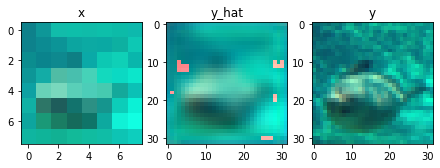

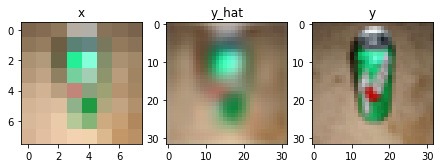

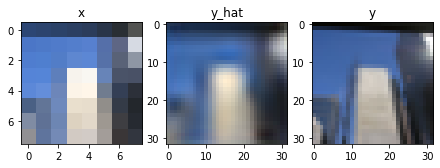

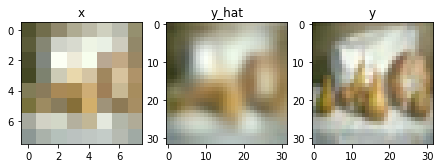

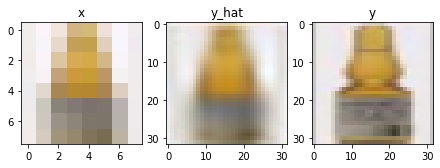

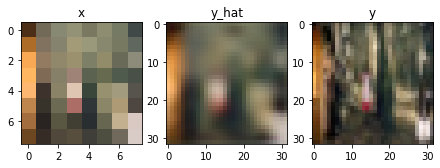

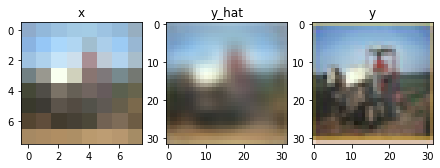

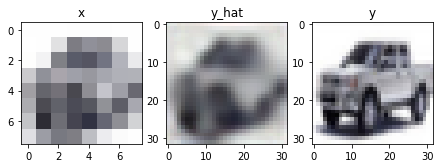

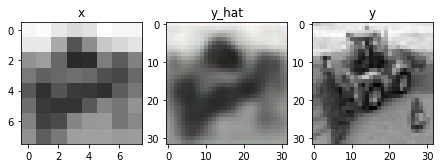

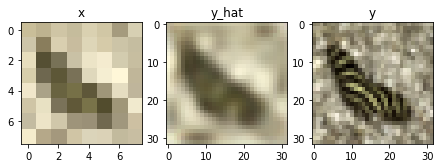

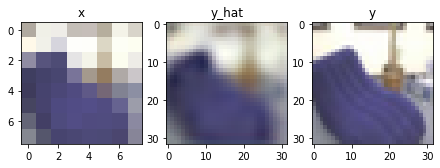

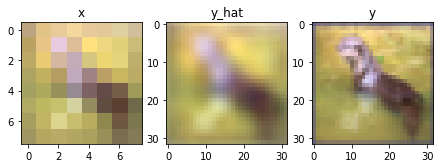

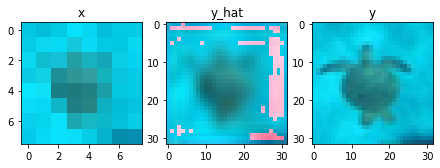

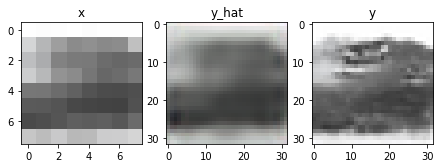

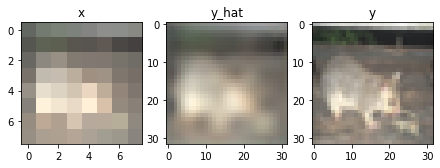

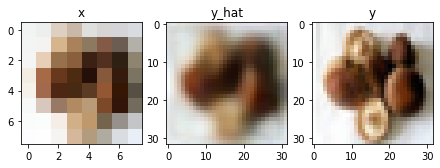

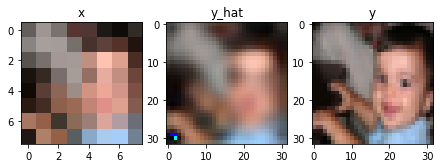

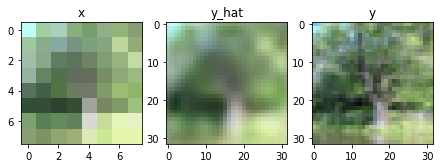

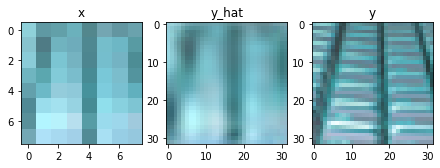

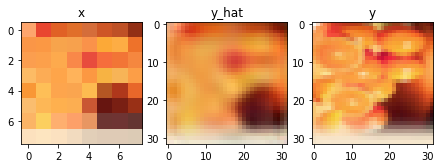

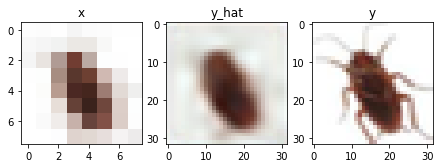

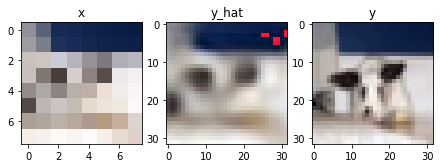

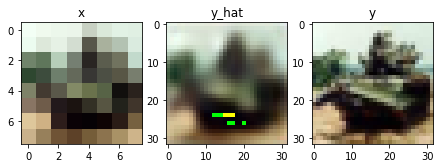

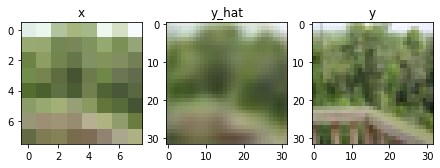

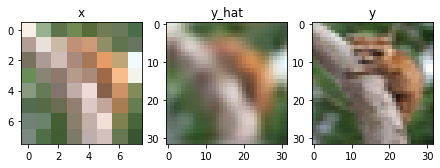

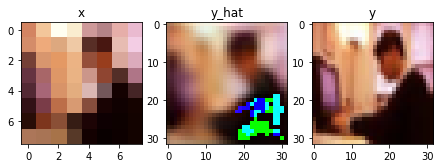

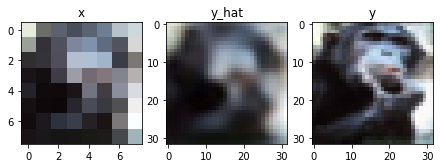

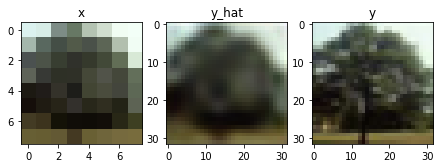

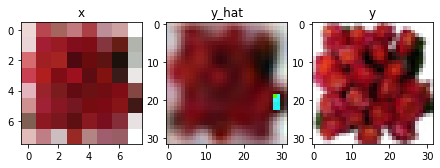

Train Epoch: 4 [0/45000 (0%)]	Loss: 0.007882
Train Epoch: 4 [320/45000 (1%)]	Loss: 0.007402
Train Epoch: 4 [640/45000 (1%)]	Loss: 0.007187
Train Epoch: 4 [960/45000 (2%)]	Loss: 0.009796
Train Epoch: 4 [1280/45000 (3%)]	Loss: 0.006164
Train Epoch: 4 [1600/45000 (4%)]	Loss: 0.007091
Train Epoch: 4 [1920/45000 (4%)]	Loss: 0.008395
Train Epoch: 4 [2240/45000 (5%)]	Loss: 0.007860
Train Epoch: 4 [2560/45000 (6%)]	Loss: 0.008754
Train Epoch: 4 [2880/45000 (6%)]	Loss: 0.008297
Train Epoch: 4 [3200/45000 (7%)]	Loss: 0.007125
Train Epoch: 4 [3520/45000 (8%)]	Loss: 0.006572
Train Epoch: 4 [3840/45000 (9%)]	Loss: 0.007548
Train Epoch: 4 [4160/45000 (9%)]	Loss: 0.005701
Train Epoch: 4 [4480/45000 (10%)]	Loss: 0.007921
Train Epoch: 4 [4800/45000 (11%)]	Loss: 0.007841
Train Epoch: 4 [5120/45000 (11%)]	Loss: 0.008152
Train Epoch: 4 [5440/45000 (12%)]	Loss: 0.006745
Train Epoch: 4 [5760/45000 (13%)]	Loss: 0.007488
Train Epoch: 4 [6080/45000 (14%)]	Loss: 0.008784
Train Epoch: 4 [6400/45000 (14%)]	Loss: 

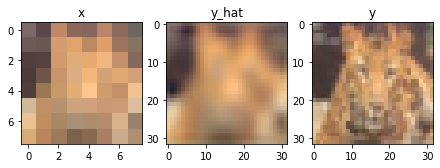

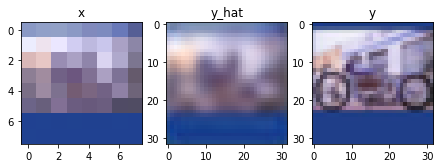

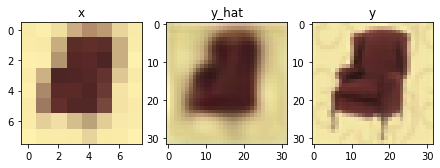

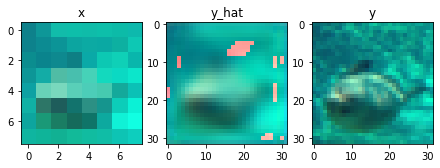

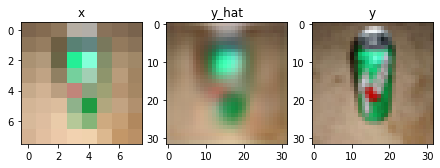

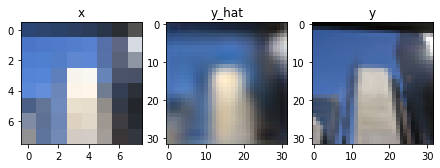

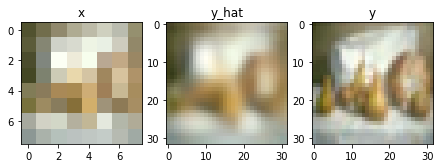

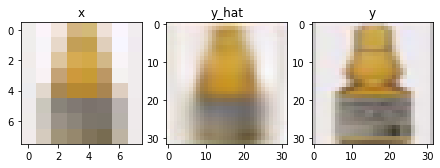

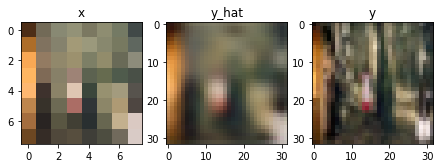

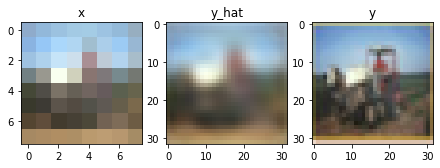

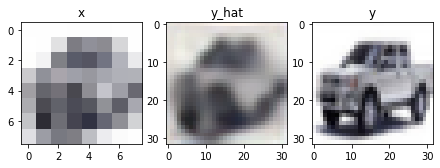

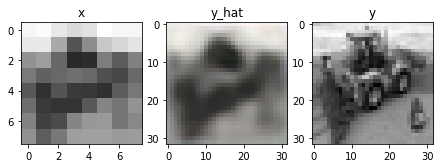

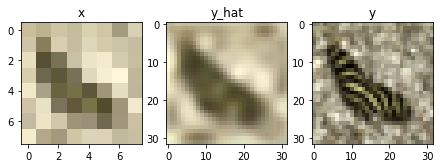

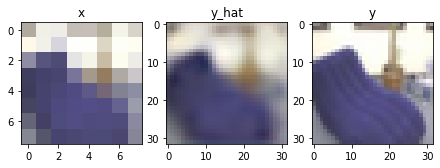

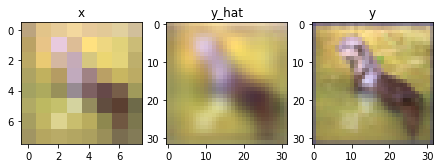

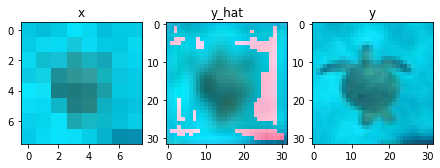

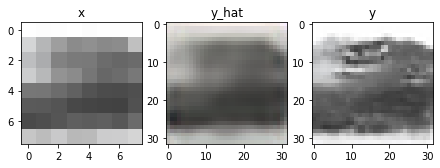

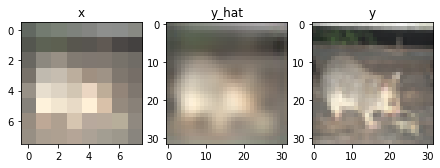

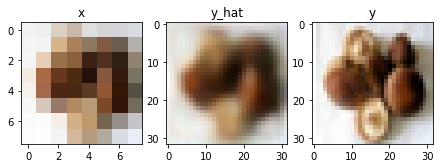

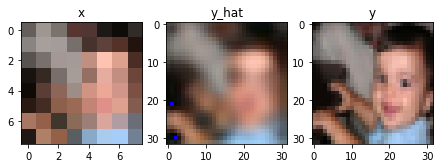

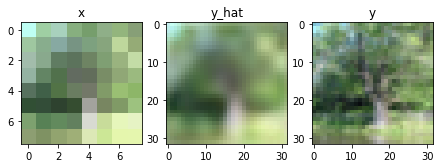

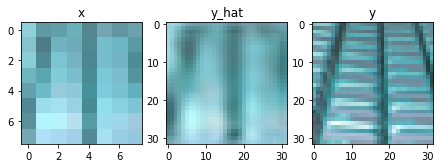

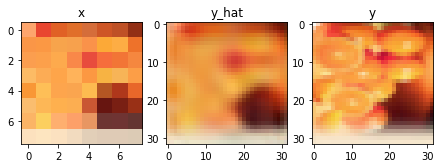

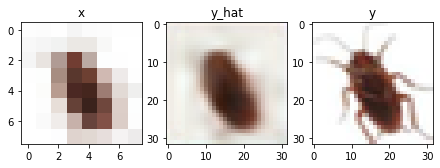

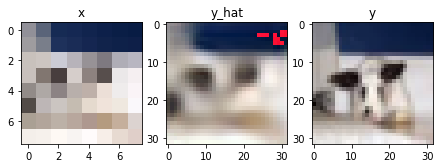

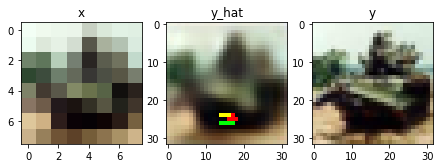

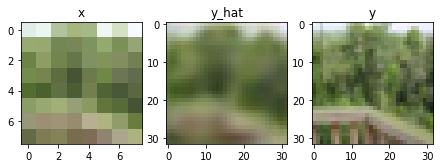

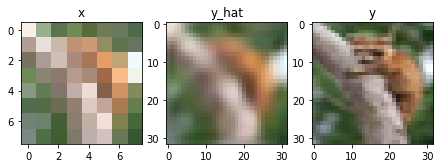

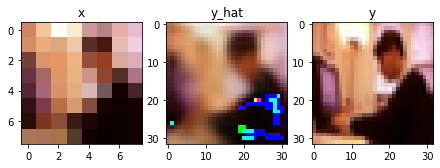

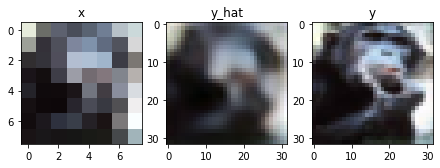

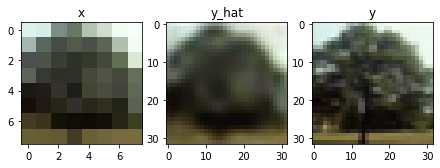

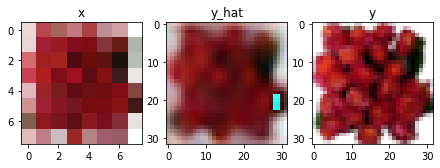

Train Epoch: 5 [0/45000 (0%)]	Loss: 0.007869
Train Epoch: 5 [320/45000 (1%)]	Loss: 0.007358
Train Epoch: 5 [640/45000 (1%)]	Loss: 0.007046
Train Epoch: 5 [960/45000 (2%)]	Loss: 0.009732
Train Epoch: 5 [1280/45000 (3%)]	Loss: 0.006107
Train Epoch: 5 [1600/45000 (4%)]	Loss: 0.007049
Train Epoch: 5 [1920/45000 (4%)]	Loss: 0.008287
Train Epoch: 5 [2240/45000 (5%)]	Loss: 0.007788
Train Epoch: 5 [2560/45000 (6%)]	Loss: 0.008544
Train Epoch: 5 [2880/45000 (6%)]	Loss: 0.008060
Train Epoch: 5 [3200/45000 (7%)]	Loss: 0.007031
Train Epoch: 5 [3520/45000 (8%)]	Loss: 0.006437
Train Epoch: 5 [3840/45000 (9%)]	Loss: 0.007353
Train Epoch: 5 [4160/45000 (9%)]	Loss: 0.005565
Train Epoch: 5 [4480/45000 (10%)]	Loss: 0.007781
Train Epoch: 5 [4800/45000 (11%)]	Loss: 0.007711
Train Epoch: 5 [5120/45000 (11%)]	Loss: 0.008127
Train Epoch: 5 [5440/45000 (12%)]	Loss: 0.006666
Train Epoch: 5 [5760/45000 (13%)]	Loss: 0.007512
Train Epoch: 5 [6080/45000 (14%)]	Loss: 0.008710
Train Epoch: 5 [6400/45000 (14%)]	Loss: 

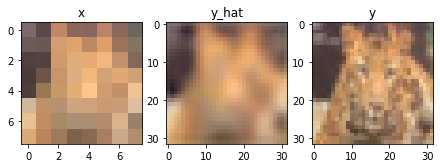

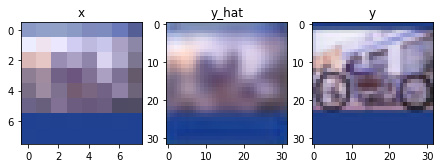

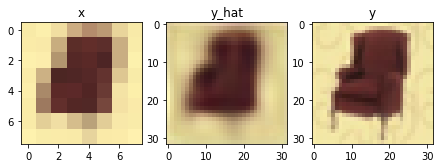

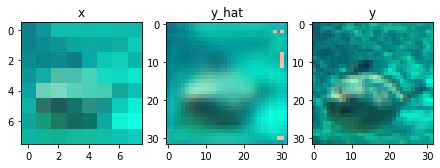

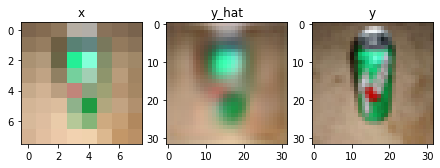

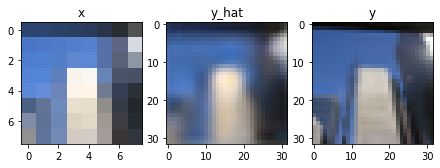

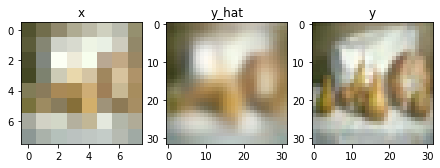

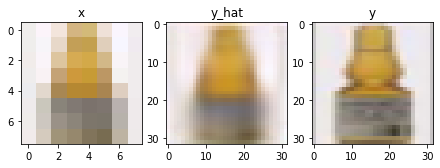

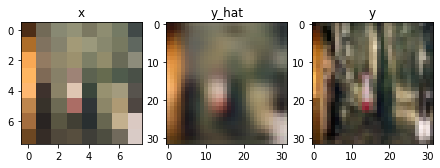

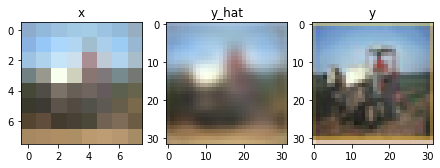

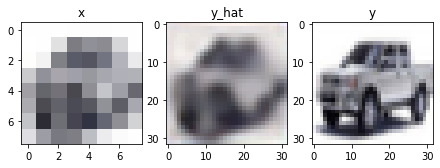

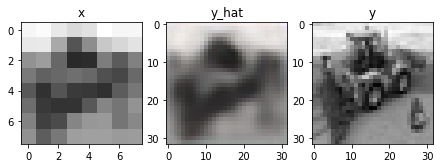

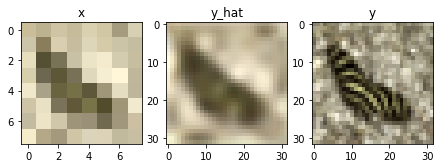

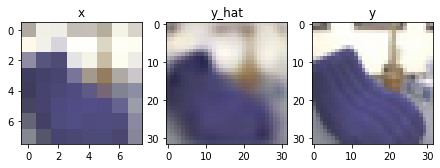

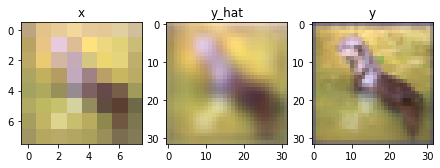

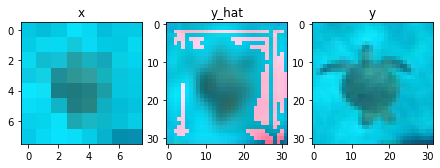

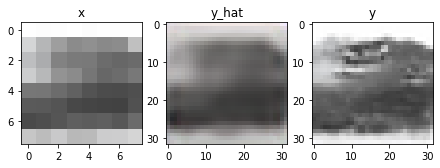

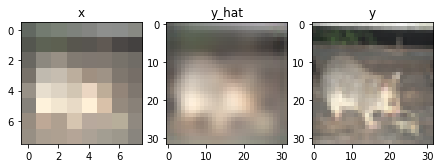

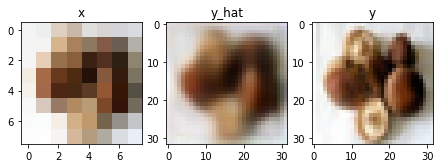

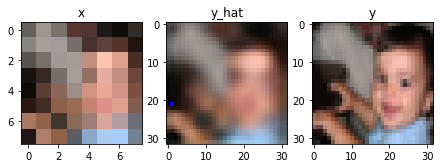

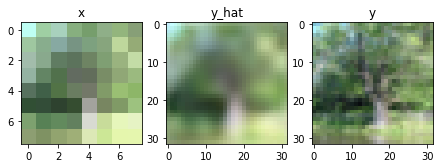

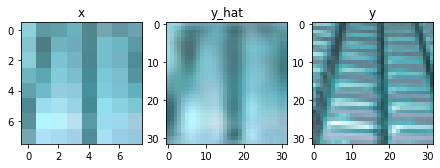

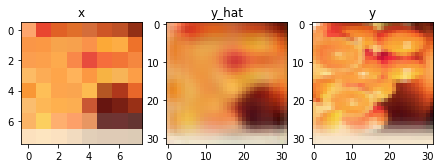

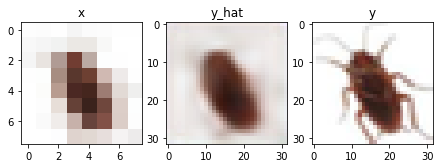

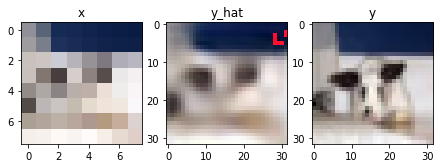

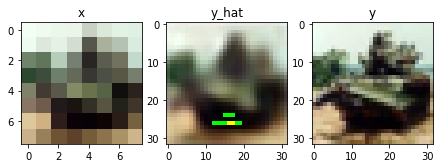

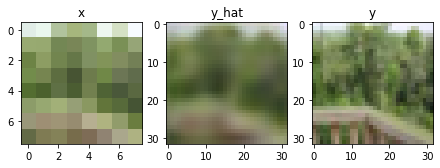

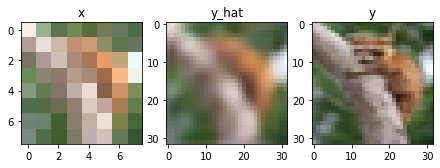

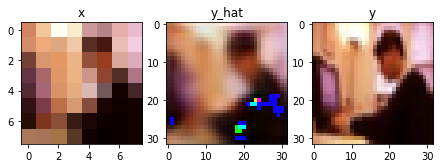

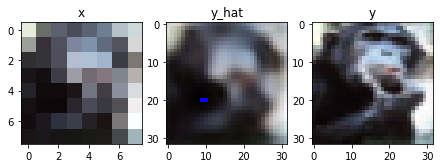

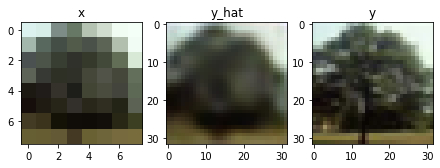

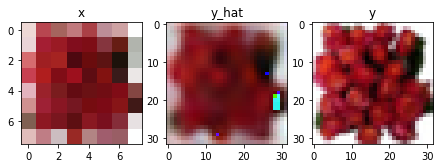

In [99]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
  # input() # DELETE THIS TO CONTINUE TRAINING!

Loss: tensor(35026.8945)


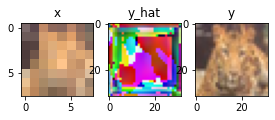

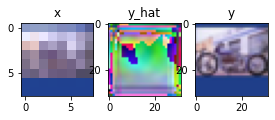

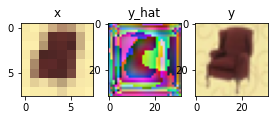

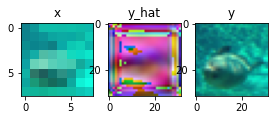

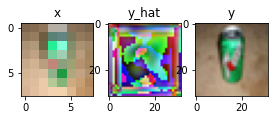

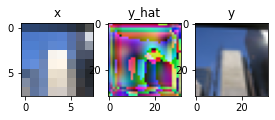

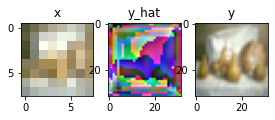

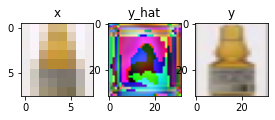

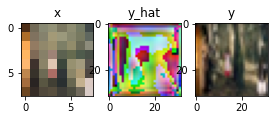

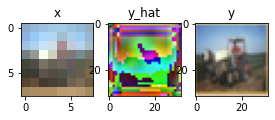

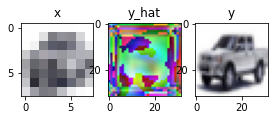

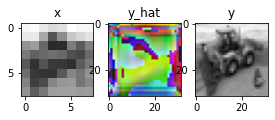

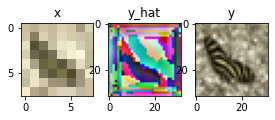

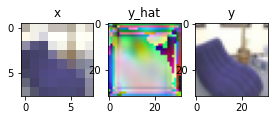

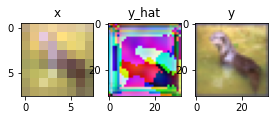

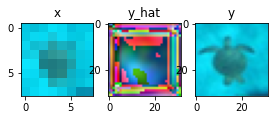

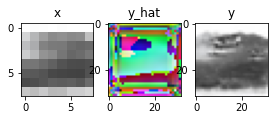

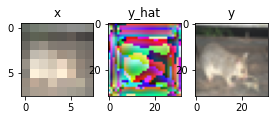

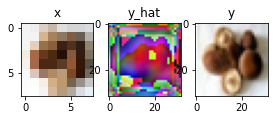

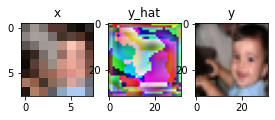

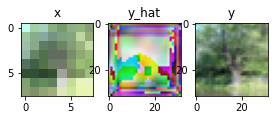

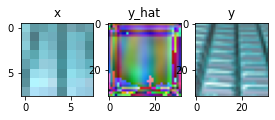

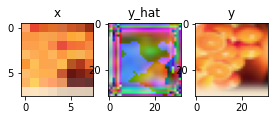

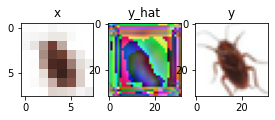

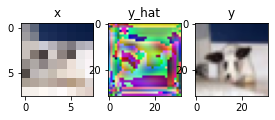

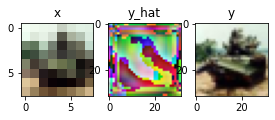

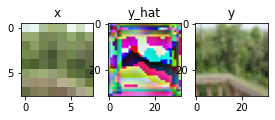

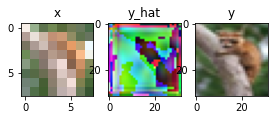

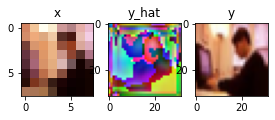

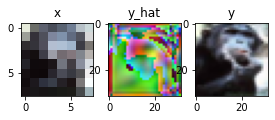

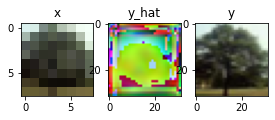

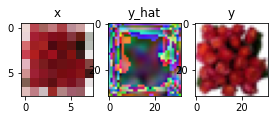

In [94]:
test()

In [100]:
torch.save(network.state_dict(), "./dense_model")